## 1. Importing libraries

In [1]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

## 2. Display settings

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
sklearn.set_config(transform_output="pandas") # Gives the output of sklearn transformers in pandas format not numpy

In [4]:
import warnings

warnings.filterwarnings("ignore")

## 3. Read the data

In [5]:
import os
PROJECT_DIR = r"C:\Users\cocod\OneDrive\Desktop\fligh-sagemaker-project"
DATA_DIR = "data"

In [6]:
def get_data(name):
    file_name = f"{name}.csv"
    file_path = os.path.join(PROJECT_DIR, DATA_DIR, file_name)
    return pd.read_csv(file_path)

In [7]:
train = get_data("train")

In [8]:
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-03-03,Delhi,Cochin,21:05:00,00:20:00,195,0.0,No Info,7673
1,Jet Airways,2019-05-01,Kolkata,Banglore,18:55:00,12:00:00,1025,1.0,In-flight meal not included,9663
2,Air India,2019-06-06,Mumbai,Hyderabad,06:20:00,07:40:00,80,0.0,No Info,3100
3,Air India,2019-05-12,Kolkata,Banglore,05:50:00,20:25:00,875,2.0,No Info,12513
4,Jet Airways,2019-04-01,Kolkata,Banglore,20:25:00,10:55:00,870,1.0,No Info,11467


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [8]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

In [11]:
X_train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Indigo,2019-03-03,Delhi,Cochin,21:05:00,00:20:00,195,0.0,No Info
1,Jet Airways,2019-05-01,Kolkata,Banglore,18:55:00,12:00:00,1025,1.0,In-flight meal not included
2,Air India,2019-06-06,Mumbai,Hyderabad,06:20:00,07:40:00,80,0.0,No Info
3,Air India,2019-05-12,Kolkata,Banglore,05:50:00,20:25:00,875,2.0,No Info
4,Jet Airways,2019-04-01,Kolkata,Banglore,20:25:00,10:55:00,870,1.0,No Info
...,...,...,...,...,...,...,...,...,...
635,Indigo,2019-06-03,Delhi,Cochin,23:30:00,04:35:00,305,1.0,No Info
636,Jet Airways,2019-03-24,Kolkata,Banglore,21:10:00,18:10:00,1260,1.0,No Info
637,Multiple Carriers,2019-06-12,Delhi,Cochin,10:00:00,19:15:00,555,1.0,No Info
638,Jet Airways,2019-06-12,Kolkata,Banglore,08:25:00,19:50:00,685,1.0,In-flight meal not included


In [12]:
y_train

0       7673
1       9663
2       3100
3      12513
4      11467
       ...  
635    11378
636    13759
637    14848
638     9899
639     5899
Name: price, Length: 640, dtype: int64

## 4. Transformation_Operations

In [13]:
X_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

### 4.1 airline

In [14]:
X_train.airline

0                 Indigo
1            Jet Airways
2              Air India
3              Air India
4            Jet Airways
             ...        
635               Indigo
636          Jet Airways
637    Multiple Carriers
638          Jet Airways
639             Spicejet
Name: airline, Length: 640, dtype: object

In [9]:
air_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)), #n_categories=2 means group only if there are at least 2 categories
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
635,0.0,1.0,0.0,0.0,0.0
636,0.0,0.0,1.0,0.0,0.0
637,0.0,0.0,0.0,1.0,0.0
638,0.0,0.0,1.0,0.0,0.0


### 4.2 date_of_journey

In [22]:
X_train.date_of_journey

0      2019-03-03
1      2019-05-01
2      2019-06-06
3      2019-05-12
4      2019-04-01
          ...    
635    2019-06-03
636    2019-03-24
637    2019-06-12
638    2019-06-12
639    2019-04-15
Name: date_of_journey, Length: 640, dtype: object

In [10]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
    ("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.000000,1.000000,0.016949
1,0.666667,0.529412,0.333333,0.516949
2,1.000000,0.823529,0.500000,0.822034
3,0.666667,0.588235,1.000000,0.610169
4,0.333333,0.294118,0.000000,0.262712
...,...,...,...,...
635,1.000000,0.823529,0.000000,0.796610
636,0.000000,0.176471,1.000000,0.194915
637,1.000000,0.882353,0.333333,0.872881
638,1.000000,0.882353,0.333333,0.872881


### 4.3 source & destination

In [28]:
X_train.source

0        Delhi
1      Kolkata
2       Mumbai
3      Kolkata
4      Kolkata
        ...   
635      Delhi
636    Kolkata
637      Delhi
638    Kolkata
639      Delhi
Name: source, Length: 640, dtype: object

In [29]:
X_train.destination

0         Cochin
1       Banglore
2      Hyderabad
3       Banglore
4       Banglore
         ...    
635       Cochin
636     Banglore
637       Cochin
638     Banglore
639       Cochin
Name: destination, Length: 640, dtype: object

In [11]:
location_subset = X_train.loc[:, ["source", "destination"]]

In [31]:
location_subset

,source,destination
0,Delhi,Cochin
1,Kolkata,Banglore
2,Mumbai,Hyderabad
3,Kolkata,Banglore
4,Kolkata,Banglore
...,...,...
635,Delhi,Cochin
636,Kolkata,Banglore
637,Delhi,Cochin
638,Kolkata,Banglore


In [12]:
location_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", MeanEncoder()),
    ("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,1.060801,1.058646
1,-0.209730,-0.219205
2,-2.007415,-0.799442
3,-0.209730,-0.219205
4,-0.209730,-0.219205
...,...,...
635,1.060801,1.058646
636,-0.209730,-0.219205
637,1.060801,1.058646
638,-0.209730,-0.219205


In [13]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [14]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    return (
        X
        .assign(**{
            f"{col}_is_north" : X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
635,1,0
636,1,0
637,1,0
638,1,0


In [15]:
location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,1.060801,1.058646,1,0
1,-0.209730,-0.219205,1,0
2,-2.007415,-0.799442,1,0
3,-0.209730,-0.219205,1,0
4,-0.209730,-0.219205,1,0
...,...,...,...,...
635,1.060801,1.058646,1,0
636,-0.209730,-0.219205,1,0
637,1.060801,1.058646,1,0
638,-0.209730,-0.219205,1,0


### 4.4 arrival_time & dep_time

In [46]:
X_train.arrival_time

0      00:20:00
1      12:00:00
2      07:40:00
3      20:25:00
4      10:55:00
         ...   
635    04:35:00
636    18:10:00
637    19:15:00
638    19:50:00
639    22:05:00
Name: arrival_time, Length: 640, dtype: object

In [48]:
X_train.dep_time

0      21:05:00
1      18:55:00
2      06:20:00
3      05:50:00
4      20:25:00
         ...   
635    23:30:00
636    21:10:00
637    10:00:00
638    08:25:00
639    15:45:00
Name: dep_time, Length: 640, dtype: object

In [16]:
time_subset = X_train.loc[:, ["arrival_time", "dep_time"]]
time_subset

,arrival_time,dep_time
0,00:20:00,21:05:00
1,12:00:00,18:55:00
2,07:40:00,06:20:00
3,20:25:00,05:50:00
4,10:55:00,20:25:00
...,...,...
635,04:35:00,23:30:00
636,18:10:00,21:10:00
637,19:15:00,10:00:00
638,19:50:00,08:25:00


In [17]:
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour", "minute"]))
])

time_pipe1.fit_transform(time_subset)

,arrival_time_hour,arrival_time_minute,dep_time_hour,dep_time_minute
0,0,20,21,5
1,12,0,18,55
2,7,40,6,20
3,20,25,5,50
4,10,55,20,25
...,...,...,...,...
635,4,35,23,30
636,18,10,21,10
637,19,15,10,0
638,19,50,8,25


In [18]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)


,arrival_time_part_of_day,dep_time_part_of_day
0,night,night
1,afternoon,evening
2,morning,morning
3,night,morning
4,morning,night
...,...,...
635,morning,night
636,evening,night
637,evening,morning
638,evening,morning


In [19]:
time_pipe2 = Pipeline(steps=[
    ("part", FunctionTransformer(func=part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,arrival_time_part_of_day,dep_time_part_of_day
0,1.000000,0.103774
1,0.000000,0.198113
2,0.722222,1.000000
3,1.000000,1.000000
4,0.722222,0.103774
...,...,...
635,0.722222,0.103774
636,0.677778,0.103774
637,0.677778,1.000000
638,0.677778,1.000000


In [20]:
time_transformer = FeatureUnion(transformer_list=[
    ("part1", time_pipe1),
    ("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,arrival_time_hour,arrival_time_minute,dep_time_hour,dep_time_minute,arrival_time_part_of_day,dep_time_part_of_day
0,0,20,21,5,1.000000,0.103774
1,12,0,18,55,0.000000,0.198113
2,7,40,6,20,0.722222,1.000000
3,20,25,5,50,1.000000,1.000000
4,10,55,20,25,0.722222,0.103774
...,...,...,...,...,...,...
635,4,35,23,30,0.722222,0.103774
636,18,10,21,10,0.677778,0.103774
637,19,15,10,0,0.677778,1.000000
638,19,50,8,25,0.677778,1.000000


### 4.5 duration

In [58]:
X_train.duration

0       195
1      1025
2        80
3       875
4       870
       ... 
635     305
636    1260
637     555
638     685
639     380
Name: duration, Length: 640, dtype: int64

In [21]:
(
    X_train
    .duration
    .quantile([0.25, 0.5, 0.75])
    .values
    .reshape(-1, 1)
)

array([[175.  ],
       [505.  ],
       [926.25]])

In [22]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [23]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000e+00,0.0,0.904837,0.904837
1,0.000000e+00,0.0,1.000000,1.000000
2,0.000000e+00,0.0,0.904837,0.904837
3,0.000000e+00,0.0,0.904837,0.904837
4,0.000000e+00,0.0,1.000000,1.000000
...,...,...,...,...
635,4.251284e-173,0.0,1.000000,1.000000
636,0.000000e+00,0.0,1.000000,1.000000
637,0.000000e+00,0.0,1.000000,1.000000
638,0.000000e+00,0.0,1.000000,1.000000


In [24]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)


In [25]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)


In [26]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])


,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.338734,-0.154969,-0.079305,1.0,0,-0.891392
1,-0.338734,-0.154969,-0.079305,2.0,1,0.782215
2,-0.338734,-0.154969,-0.079305,0.0,0,-1.123277
3,-0.338734,-0.154969,-0.079305,2.0,0,0.479756
4,-0.338734,-0.154969,-0.079305,2.0,0,0.469674
...,...,...,...,...,...,...
635,-0.338734,-0.154969,-0.079305,1.0,0,-0.669589
636,-0.338734,-0.154969,-0.079305,2.0,1,1.256068
637,-0.338734,-0.154969,-0.079305,2.0,0,-0.165490
638,-0.338734,-0.154969,-0.079305,2.0,0,0.096641


### 4.6 total_stops

In [70]:
X_train.total_stops

0      0.0
1      1.0
2      0.0
3      2.0
4      1.0
      ... 
635    1.0
636    1.0
637    1.0
638    1.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [27]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,0.0,1
1,1.0,0
2,0.0,1
3,2.0,0
4,1.0,0
...,...,...
635,1.0,0
636,1.0,0
637,1.0,0
638,1.0,0


### 4.7 additional_info

In [72]:
X_train.additional_info

0                          No Info
1      In-flight meal not included
2                          No Info
3                          No Info
4                          No Info
                  ...             
635                        No Info
636                        No Info
637                        No Info
638    In-flight meal not included
639                        No Info
Name: additional_info, Length: 640, dtype: object

In [28]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,1.0,0.0,0.0


In [29]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [30]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [31]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])


,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,1.0,0.0,0.0,1


### 4.8. Column Transformer

In [32]:
column_transformer = ColumnTransformer(transformers=[
    ("air", air_transformer, ["airline"]),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("location", location_transformer, ["source", "destination"]),
    ("time", time_transformer, ["dep_time", "arrival_time"]),
    ("dur", duration_transformer, ["duration"]),
    ("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.016949,1.060801,1.058646,1,0,21,5,0,20,0.103774,1.000000,-0.338734,-0.154969,-0.079305,1.0,0,-0.891392,0.0,1,0.0,1.0,0.0,0
1,0.0,0.0,1.0,0.0,0.0,0.666667,0.529412,0.333333,0.516949,-0.209730,-0.219205,1,0,18,55,12,0,0.198113,0.000000,-0.338734,-0.154969,-0.079305,2.0,1,0.782215,1.0,0,1.0,0.0,0.0,1
2,1.0,0.0,0.0,0.0,0.0,1.000000,0.823529,0.500000,0.822034,-2.007415,-0.799442,1,0,6,20,7,40,1.000000,0.722222,-0.338734,-0.154969,-0.079305,0.0,0,-1.123277,0.0,1,0.0,1.0,0.0,0
3,1.0,0.0,0.0,0.0,0.0,0.666667,0.588235,1.000000,0.610169,-0.209730,-0.219205,1,0,5,50,20,25,1.000000,1.000000,-0.338734,-0.154969,-0.079305,2.0,0,0.479756,2.0,0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.333333,0.294118,0.000000,0.262712,-0.209730,-0.219205,1,0,20,25,10,55,0.103774,0.722222,-0.338734,-0.154969,-0.079305,2.0,0,0.469674,1.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.0,0.0,0.0,1.000000,0.823529,0.000000,0.796610,1.060801,1.058646,1,0,23,30,4,35,0.103774,0.722222,-0.338734,-0.154969,-0.079305,1.0,0,-0.669589,1.0,0,0.0,1.0,0.0,0
636,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,1.000000,0.194915,-0.209730,-0.219205,1,0,21,10,18,10,0.103774,0.677778,-0.338734,-0.154969,-0.079305,2.0,1,1.256068,1.0,0,0.0,1.0,0.0,0
637,0.0,0.0,0.0,1.0,0.0,1.000000,0.882353,0.333333,0.872881,1.060801,1.058646,1,0,10,0,19,15,1.000000,0.677778,-0.338734,-0.154969,-0.079305,2.0,0,-0.165490,1.0,0,0.0,1.0,0.0,0
638,0.0,0.0,1.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,-0.209730,-0.219205,1,0,8,25,19,50,1.000000,0.677778,-0.338734,-0.154969,-0.079305,2.0,0,0.096641,1.0,0,1.0,0.0,0.0,1


## 5. Feature Selection

In [33]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
)

## 6. Putting it all together

In [34]:
preprocessor = Pipeline(steps=[
    ("ct", column_transformer),
    ("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Jet Airways,dur__duration_cat,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,-0.891392,0.0,1
1,1.0,2.0,0.782215,1.0,0
2,0.0,0.0,-1.123277,0.0,1
3,0.0,2.0,0.479756,2.0,0
4,1.0,2.0,0.469674,1.0,0
...,...,...,...,...,...
635,0.0,1.0,-0.669589,1.0,0
636,1.0,2.0,1.256068,1.0,0
637,0.0,2.0,-0.165490,1.0,0
638,1.0,2.0,0.096641,1.0,0


In [35]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': -0.042725756132543515,
 'air__airline_Indigo': 0.08778249167535175,
 'air__airline_Jet Airways': 0.17282378295619175,
 'air__airline_Multiple Carriers': -0.013860096701218386,
 'air__airline_Other': 0.07721868370513425,
 'doj__date_of_journey_month': 0.043576575303504894,
 'doj__date_of_journey_week': 0.09976519648043287,
 'doj__date_of_journey_day_of_week': -0.03974423872744892,
 'doj__date_of_journey_day_of_year': 0.06290614947747519,
 'location__source': 0.08714787727492361,
 'location__destination': 0.08899712509824009,
 'location__source_is_north': -0.014371853884170912,
 'location__destination_is_north': -0.014371853884170912,
 'time__dep_time_hour': -0.059536724150835996,
 'time__dep_time_minute': -0.012685248743378322,
 'time__arrival_time_hour': 0.03587477216952554,
 'time__arrival_time_minute': 0.007787129284683725,
 'time__dep_time_part_of_day': -0.05319364132673576,
 'time__arrival_time_part_of_day': 0.000347408120162096,
 'dur__duration_rbf_25': 

In [36]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__dep_time_hour': -0.059536724150835996,
 'time__dep_time_part_of_day': -0.05319364132673576,
 'dur__duration_rbf_50': -0.04343274000512346,
 'air__airline_Air India': -0.042725756132543515,
 'info__additional_info_No Info': -0.04120879965779234,
 'info__additional_info': -0.04120879965779234,
 'doj__date_of_journey_day_of_week': -0.03974423872744892,
 'info__additional_info_In-flight meal not included': -0.03884861663995398,
 'dur__duration_rbf_75': -0.03780288832536227,
 'location__source_is_north': -0.014371853884170912,
 'location__destination_is_north': -0.014371853884170912,
 'air__airline_Multiple Carriers': -0.013860096701218386,
 'time__dep_time_minute': -0.012685248743378322,
 'info__additional_info_Other': -0.011796688455618543,
 'time__arrival_time_part_of_day': 0.000347408120162096,
 'time__arrival_time_minute': 0.007787129284683725,
 'time__arrival_time_hour': 0.03587477216952554,
 'doj__date_of_journey_month': 0.043576575303504894,
 'doj__date_of_journey_day_of_yea

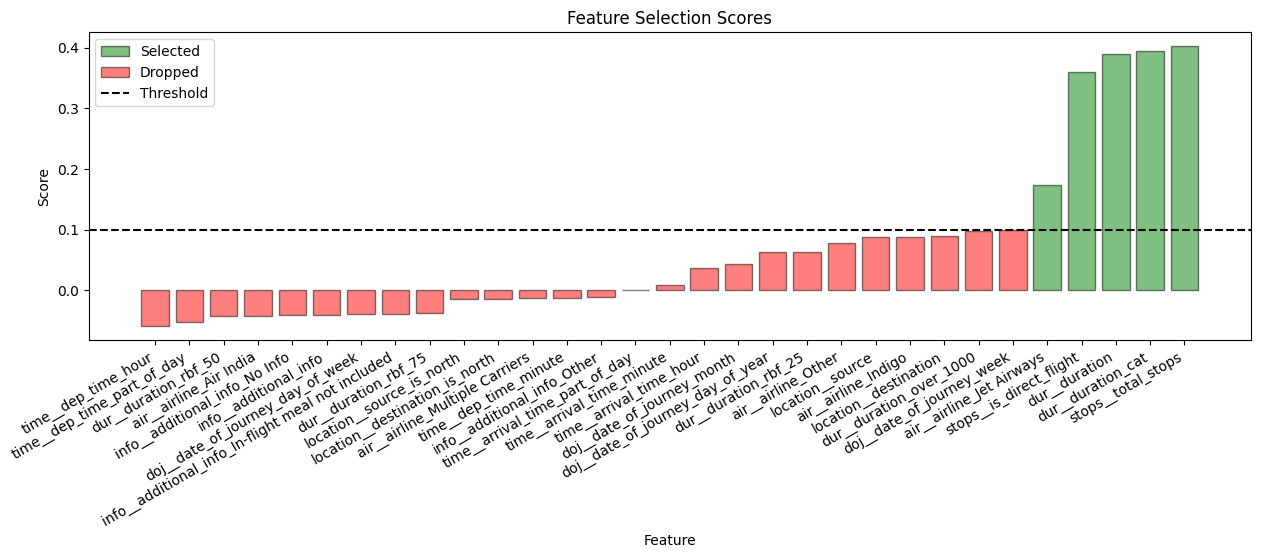

In [37]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()